Install pyspark

In [4]:
pip install pyspark


     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 317.0/317.0 MB 3.6 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
  Created wheel for pyspark: filename=pyspark-3.5.1-py2.py3-none-any.whl size=317488491 sha256=18e27152c63d52add78644d8d45ad34fbfc71d82191339ea6258d1973b5feae7
  Stored in directory: /root/.cache/pip/wheels/80/1d/60/2c256ed38dddce2fdd93be545214a63e02fbd8d74fb0b7f3a6
Successfully built pyspark


Import Pyspark SQL and other libraries



In [5]:
from pyspark.sql import SparkSession
from pyspark.sql.types import StringType, IntegerType
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from pyspark.ml.feature import OneHotEncoder, StringIndexer, VectorAssembler
from pyspark.ml import Pipeline
from pyspark.ml.classification import RandomForestClassifier
from pyspark.ml.evaluation import MulticlassClassificationEvaluator
from pyspark.ml.evaluation import BinaryClassificationEvaluator


Configure SparkSession and sparkContex

In [6]:
spark = SparkSession.builder\
    .master("local[*]")\
    .appName("ML Heart Attack Pred")\
    .getOrCreate()
sc = spark.sparkContext


Import heart_attack dataset using read.csv function

In [7]:
df = spark.read.csv('/content/heart_attack1.csv', header = True, inferSchema = True)
df.printSchema()


root
 |-- State: string (nullable = true)
 |-- Sex: string (nullable = true)
 |-- GeneralHealth: string (nullable = true)
 |-- PhysicalHealthDays: integer (nullable = true)
 |-- MentalHealthDays: integer (nullable = true)
 |-- LastCheckupTime: string (nullable = true)
 |-- PhysicalActivities: string (nullable = true)
 |-- SleepHours: integer (nullable = true)
 |-- RemovedTeeth: string (nullable = true)
 |-- HadHeartAttack: string (nullable = true)
 |-- HadAngina: string (nullable = true)
 |-- HadStroke: string (nullable = true)
 |-- HadAsthma: string (nullable = true)
 |-- HadSkinCancer: string (nullable = true)
 |-- HadCOPD: string (nullable = true)
 |-- HadDepressiveDisorder: string (nullable = true)
 |-- HadKidneyDisease: string (nullable = true)
 |-- HadArthritis: string (nullable = true)
 |-- HadDiabetes: string (nullable = true)
 |-- DeafOrHardOfHearing: string (nullable = true)
 |-- BlindOrVisionDifficulty: string (nullable = true)
 |-- DifficultyConcentrating: string (nullable 

Explore the data set

In [8]:

pd.DataFrame(df.take(5), columns = df.columns)


,State,Sex,GeneralHealth,PhysicalHealthDays,MentalHealthDays,LastCheckupTime,PhysicalActivities,SleepHours,RemovedTeeth,HadHeartAttack,...,HeightInMeters,WeightInKilograms,BMI,AlcoholDrinkers,HIVTesting,FluVaxLast12,PneumoVaxEver,TetanusLast10Tdap,HighRiskLastYear,CovidPos
0,Ohio,Female,Fair,4,0,Within past year,Yes,7,Some,No,...,1.70,77.11,26.630000,No,No,Yes,Yes,No,No,No
1,Minnesota,Female,Good,15,30,Within past year,No,6,Some,No,...,1.65,82.55,30.321396,Yes,Yes,Yes,No,"Yes, received Tdap",No,No
2,Minnesota,Female,Very good,0,1,Within past 2 years,Yes,8,None of them,No,...,1.68,90.72,32.280000,Yes,No,Yes,Yes,"Yes, received Tdap",No,No
3,New Jersey,Male,Good,0,0,Within past year,No,7,None of them,No,...,1.75,95.25,31.010000,No,No,Yes,Yes,"Yes, but not sure what type",No,No
4,Texas,Male,Excellent,1,0,Within past year,Yes,7,None of them,No,...,1.75,70.31,22.890000,No,No,No,Yes,"Yes, received Tdap",No,No


Convert Column Type to string

Drop state column to reduce noise

In [9]:
#drop HeightInMeters and WeightInKilograms
df = df.drop("State")

Derive numerical variables

In [10]:
numeric_cols = [t[0] for t in df.dtypes if (t[1] == 'int') | (t[1] == 'double')]

In [11]:
df.select(numeric_cols).describe().toPandas()


,summary,PhysicalHealthDays,MentalHealthDays,SleepHours,HeightInMeters,WeightInKilograms,BMI
0,count,40000,40000,40000,40000,40000,40000
1,mean,3.84445,3.9705,7.0078,1.7030132499999917,80.8777907500013,27.818363632617373
2,stddev,8.156780463159977,7.947783271546439,1.2428104338330783,0.10325061424355336,17.76090359889184,5.318102610734452
3,min,0,0,3,1.42,28.12,9.208993998
4,max,30,30,11,1.98,135.62,57.91637812


Check correlation between numerical variables

Text(0.5, 1.0, 'Correlation Heatmap')

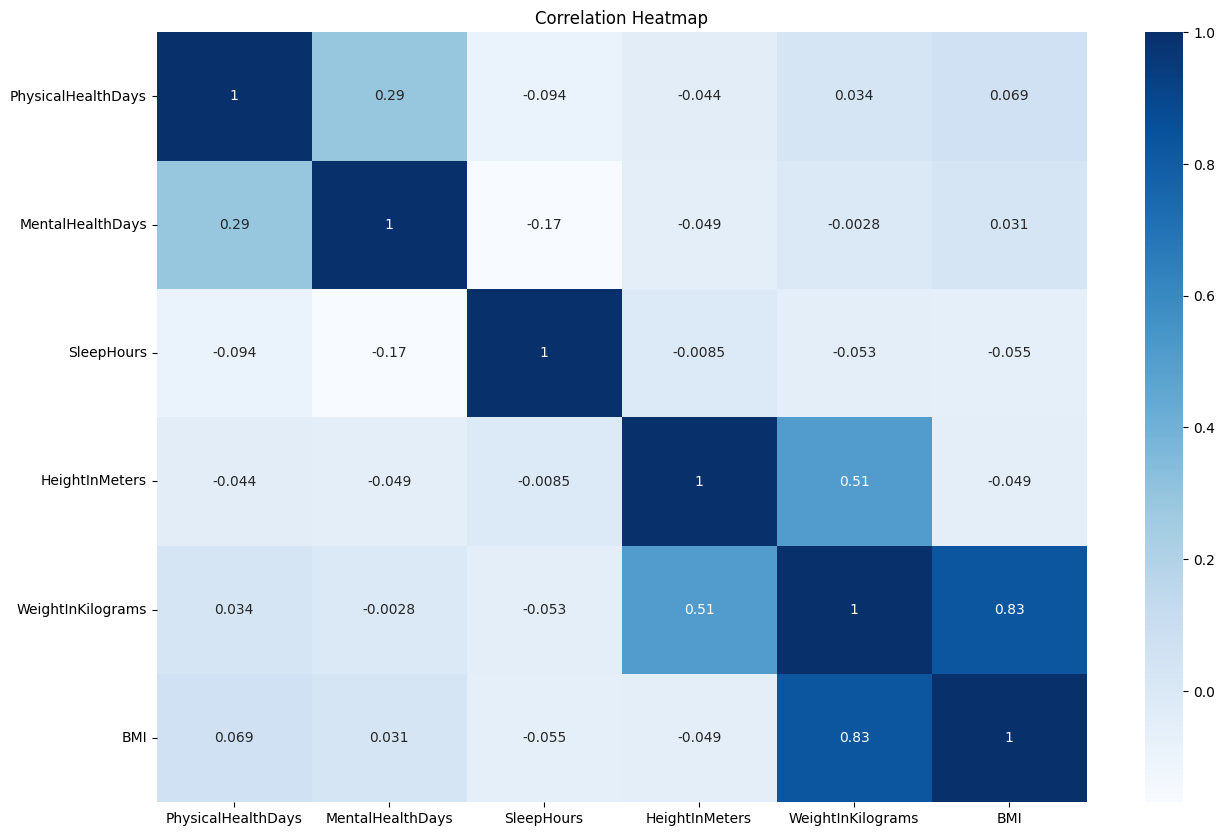

In [12]:


#convert numeric_cols to a dataFrame
numeric_data = df.select(numeric_cols).toPandas()
#visualise the correlations between the numeric variables using a heatmap
fig = plt.figure(figsize = (15,10))
sns.heatmap(numeric_data.corr(method = 'pearson'), annot = True, cmap = "Blues")
plt.title("Correlation Heatmap")



WeightInKilograms shows a high positive correlation of 0.83 with BMI and a positive correlation of 0.51 with HeightInMeters. Therefore, considering BMI is calculated using both Height and Weight, these two variables will be dropped.

In [13]:
#drop HeightInMeters and WeightInKilograms
df = df.drop("HeightInMeters","WeightInKilograms")

#print df
df.printSchema()

root
 |-- Sex: string (nullable = true)
 |-- GeneralHealth: string (nullable = true)
 |-- PhysicalHealthDays: integer (nullable = true)
 |-- MentalHealthDays: integer (nullable = true)
 |-- LastCheckupTime: string (nullable = true)
 |-- PhysicalActivities: string (nullable = true)
 |-- SleepHours: integer (nullable = true)
 |-- RemovedTeeth: string (nullable = true)
 |-- HadHeartAttack: string (nullable = true)
 |-- HadAngina: string (nullable = true)
 |-- HadStroke: string (nullable = true)
 |-- HadAsthma: string (nullable = true)
 |-- HadSkinCancer: string (nullable = true)
 |-- HadCOPD: string (nullable = true)
 |-- HadDepressiveDisorder: string (nullable = true)
 |-- HadKidneyDisease: string (nullable = true)
 |-- HadArthritis: string (nullable = true)
 |-- HadDiabetes: string (nullable = true)
 |-- DeafOrHardOfHearing: string (nullable = true)
 |-- BlindOrVisionDifficulty: string (nullable = true)
 |-- DifficultyConcentrating: string (nullable = true)
 |-- DifficultyWalking: strin

Convert categorical columns using one-hot encoding

In [14]:
# select the categorical columns
categoricalColumns = ["CovidPos", "HighRiskLastYear", "TetanusLast10Tdap", "PneumoVaxEver", "FluVaxLast12","HIVTesting","AlcoholDrinkers","AgeCategory","RaceEthnicityCategory","ChestScan","ECigaretteUsage",
                                 "SmokerStatus","DifficultyErrands","DifficultyDressingBathing","DifficultyWalking","DifficultyConcentrating","BlindOrVisionDifficulty","DeafOrHardOfHearing","HadDiabetes",
                                 "HadArthritis","HadKidneyDisease","HadDepressiveDisorder","HadCOPD","HadSkinCancer","HadAsthma","HadStroke","HadAngina","RemovedTeeth","PhysicalActivities",
                                 "LastCheckupTime","GeneralHealth","Sex"]

# create empty list to store results of StringIndexer and OneHotEncoder
stages = []


In [15]:
# for loop to index each categorical column using StringIndexer function.
#OneHotEncoder function is used to convert indexed categorical variables
for categoricalCol in categoricalColumns:
    stringIndexer = StringIndexer(inputCol = categoricalCol, outputCol = categoricalCol + 'Index')
    encoder = OneHotEncoder(inputCols=[stringIndexer.getOutputCol()], outputCols=[categoricalCol + "classVec"])
    stages = stages + [stringIndexer, encoder]

In [16]:
# encode labels to label indices
label_stringIdx = StringIndexer(inputCol = "HadHeartAttack", outputCol = 'label')
stages = stages + [label_stringIdx]


In [17]:
# VectorAssembler to combine all columns into a single vector column
numericCols = ["PhysicalHealthDays", "MentalHealthDays", "SleepHours", "BMI"]
assemblerInputs = [c + "classVec" for c in categoricalColumns] + numericCols
assembler = VectorAssembler(inputCols=assemblerInputs, outputCol = "features")
stages = stages + [assembler]


## PySpark and Machine Learning(Random Forest)

In [18]:

cols = df.columns
# steps to create the ML pipeline
pipeline = Pipeline(stages = stages)
pipelineModel = pipeline.fit(df)
df = pipelineModel.transform(df)

In [19]:
selectedCols = ['label', 'features'] + cols
df = df.select(selectedCols)
df.printSchema()

root
 |-- label: double (nullable = false)
 |-- features: vector (nullable = true)
 |-- Sex: string (nullable = true)
 |-- GeneralHealth: string (nullable = true)
 |-- PhysicalHealthDays: integer (nullable = true)
 |-- MentalHealthDays: integer (nullable = true)
 |-- LastCheckupTime: string (nullable = true)
 |-- PhysicalActivities: string (nullable = true)
 |-- SleepHours: integer (nullable = true)
 |-- RemovedTeeth: string (nullable = true)
 |-- HadHeartAttack: string (nullable = true)
 |-- HadAngina: string (nullable = true)
 |-- HadStroke: string (nullable = true)
 |-- HadAsthma: string (nullable = true)
 |-- HadSkinCancer: string (nullable = true)
 |-- HadCOPD: string (nullable = true)
 |-- HadDepressiveDisorder: string (nullable = true)
 |-- HadKidneyDisease: string (nullable = true)
 |-- HadArthritis: string (nullable = true)
 |-- HadDiabetes: string (nullable = true)
 |-- DeafOrHardOfHearing: string (nullable = true)
 |-- BlindOrVisionDifficulty: string (nullable = true)
 |-- D

In [20]:
#view the dataframe
pd.DataFrame(df.take(5), columns = df.columns)


,label,features,Sex,GeneralHealth,PhysicalHealthDays,MentalHealthDays,LastCheckupTime,PhysicalActivities,SleepHours,RemovedTeeth,...,RaceEthnicityCategory,AgeCategory,BMI,AlcoholDrinkers,HIVTesting,FluVaxLast12,PneumoVaxEver,TetanusLast10Tdap,HighRiskLastYear,CovidPos
0,0.0,"(1.0, 1.0, 1.0, 0.0, 0.0, 0.0, 0.0, 1.0, 1.0, ...",Female,Fair,4,0,Within past year,Yes,7,Some,...,White,Over-60s,26.630000,No,No,Yes,Yes,No,No,No
1,0.0,"(1.0, 1.0, 0.0, 0.0, 1.0, 0.0, 1.0, 1.0, 0.0, ...",Female,Good,15,30,Within past year,No,6,Some,...,White,Middle Aged Adults,30.321396,Yes,Yes,Yes,No,"Yes, received Tdap",No,No
2,0.0,"(1.0, 1.0, 0.0, 0.0, 1.0, 0.0, 0.0, 1.0, 1.0, ...",Female,Very good,0,1,Within past 2 years,Yes,8,None of them,...,White,Over-60s,32.280000,Yes,No,Yes,Yes,"Yes, received Tdap",No,No
3,0.0,"(1.0, 1.0, 0.0, 1.0, 0.0, 0.0, 0.0, 1.0, 1.0, ...",Male,Good,0,0,Within past year,No,7,None of them,...,Other,Young Adults,31.010000,No,No,Yes,Yes,"Yes, but not sure what type",No,No
4,0.0,"(1.0, 1.0, 0.0, 0.0, 1.0, 0.0, 0.0, 0.0, 1.0, ...",Male,Excellent,1,0,Within past year,Yes,7,None of them,...,White,Young Adults,22.890000,No,No,No,Yes,"Yes, received Tdap",No,No


Train/Test Split

In [21]:
train, test = df.randomSplit([0.7, 0.3], seed = 123)
print("Training Dataset Count: " + str(train.count()))
print("Test Dataset Count: " + str(test.count()))


Training Dataset Count: 27912
Test Dataset Count: 12088


In [22]:
from pyspark.ml.classification import DecisionTreeClassifier

dt = DecisionTreeClassifier(featuresCol = 'features', labelCol = 'label', maxDepth = 3)
dtModel = dt.fit(train)
predictions = dtModel.transform(test)

# Create evaluator
evaluator = BinaryClassificationEvaluator()

# Evaluate model
print("Test Area Under ROC: " + str(evaluator.evaluate(predictions, {evaluator.metricName: "areaUnderROC"})))

Test Area Under ROC: 0.25557371131681544


Evaluation of Decision Tree

In [23]:

evaluator = MulticlassClassificationEvaluator(labelCol="label", predictionCol="prediction")
accuracy = evaluator.evaluate(predictions)
precision = evaluator.evaluate(predictions, {evaluator.metricName: "weightedPrecision"})
recall = evaluator.evaluate(predictions, {evaluator.metricName: "weightedRecall"})
f1_score = evaluator.evaluate(predictions, {evaluator.metricName: "f1"})
print("Precision:", precision)
print("Recall:", recall)
print("F1-score:", f1_score)
print("Accuracy = %s" % (accuracy))
print("Test Error = %s" % (1.0 - accuracy))

Precision: 0.9302934148120794
Recall: 0.9480476505625414
F1-score: 0.9308236975613589
Accuracy = 0.9308236975613589
Test Error = 0.06917630243864115


Confusion matrix for decision tree

In [24]:
# Calculate the elements of the confusion matrix
TN = predictions.filter((predictions['prediction'] == 0) & (predictions['label'] == predictions['prediction'])).count()
TP = predictions.filter((predictions['prediction'] == 1) & (predictions['label'] == predictions['prediction'])).count()
FN = predictions.filter((predictions['prediction'] == 0) & (predictions['label'] != predictions['prediction'])).count()
FP = predictions.filter((predictions['prediction'] == 1) & (predictions['label'] != predictions['prediction'])).count()

# Print the elements of the confusion matrix
print("True Negatives (TN):", TN)
print("True Positives (TP):", TP)
print("False Negatives (FN):", FN)
print("False Positives (FP):", FP)

True Negatives (TN): 11396
True Positives (TP): 64
False Negatives (FN): 573
False Positives (FP): 55


Random Forest Model

In [25]:

rf = RandomForestClassifier(featuresCol = 'features', labelCol = 'label')

# fitting the training data
rfModel = rf.fit(train)

#testing the performance using testing data
predictions = rfModel.transform(test)

# showing the first 10 labels and predictions
predictions.select("label", "prediction").show(10)

# Create evaluator
evaluator = BinaryClassificationEvaluator()

# Evaluate model
print("Test Area Under ROC: " + str(evaluator.evaluate(predictions, {evaluator.metricName: "areaUnderROC"})))



+-----+----------+
|label|prediction|
+-----+----------+
|  0.0|       0.0|
|  0.0|       0.0|
|  0.0|       0.0|
|  0.0|       0.0|
|  0.0|       0.0|
|  0.0|       0.0|
|  0.0|       0.0|
|  0.0|       0.0|
|  0.0|       0.0|
|  0.0|       0.0|
+-----+----------+
only showing top 10 rows

Test Area Under ROC: 0.8856047890630021


Evaluation of random forest model

In [26]:

evaluator = MulticlassClassificationEvaluator(labelCol="label", predictionCol="prediction")
accuracy = evaluator.evaluate(predictions)
precision = evaluator.evaluate(predictions, {evaluator.metricName: "weightedPrecision"})
recall = evaluator.evaluate(predictions, {evaluator.metricName: "weightedRecall"})
f1_score = evaluator.evaluate(predictions, {evaluator.metricName: "f1"})
print("Precision:", precision)
print("Recall:", recall)
print("F1-score:", f1_score)
print("Accuracy = %s" % (accuracy))
print("Test Error = %s" % (1.0 - accuracy))

Precision: 0.8973831832062339
Recall: 0.9473031105228326
F1-score: 0.9216676934956418
Accuracy = 0.9216676934956418
Test Error = 0.07833230650435818


Confusion matrix for random forest model

In [27]:
# Calculate the elements of the confusion matrix
TN = predictions.filter((predictions['prediction'] == 0) & (predictions['label'] == predictions['prediction'])).count()
TP = predictions.filter((predictions['prediction'] == 1) & (predictions['label'] == predictions['prediction'])).count()
FN = predictions.filter((predictions['prediction'] == 0) & (predictions['label'] != predictions['prediction'])).count()
FP = predictions.filter((predictions['prediction'] == 1) & (predictions['label'] != predictions['prediction'])).count()

# Print the elements of the confusion matrix
print("True Negatives (TN):", TN)
print("True Positives (TP):", TP)
print("False Negatives (FN):", FN)
print("False Positives (FP):", FP)



True Negatives (TN): 11451
True Positives (TP): 0
False Negatives (FN): 637
False Positives (FP): 0


Gradient-Boosted Tree

In [28]:
from pyspark.ml.classification import GBTClassifier

gbt = GBTClassifier(maxIter=10)
gbtModel = gbt.fit(train)
predictions = gbtModel.transform(test)

Evaluation for Gradient-Boosted Tree

In [29]:

# Create evaluator
evaluator = BinaryClassificationEvaluator()

# Evaluate model
print("Test Area Under ROC: " + str(evaluator.evaluate(predictions, {evaluator.metricName: "areaUnderROC"})))

Test Area Under ROC: 0.8926282993800491


In [30]:
evaluator = MulticlassClassificationEvaluator(labelCol="label", predictionCol="prediction")
accuracy = evaluator.evaluate(predictions)
precision = evaluator.evaluate(predictions, {evaluator.metricName: "weightedPrecision"})
recall = evaluator.evaluate(predictions, {evaluator.metricName: "weightedRecall"})
f1_score = evaluator.evaluate(predictions, {evaluator.metricName: "f1"})
print("Precision:", precision)
print("Recall:", recall)
print("F1-score:", f1_score)
print("Accuracy = %s" % (accuracy))
print("Test Error = %s" % (1.0 - accuracy))

Precision: 0.9371262985633343
Recall: 0.9501158173395102
F1-score: 0.9386769750323692
Accuracy = 0.9386769750323692
Test Error = 0.06132302496763076


Confusion matrix for Gradient-Boosted Tree

In [31]:
# Calculate the elements of the confusion matrix
TN = predictions.filter((predictions['prediction'] == 0) & (predictions['label'] == predictions['prediction'])).count()
TP = predictions.filter((predictions['prediction'] == 1) & (predictions['label'] == predictions['prediction'])).count()
FN = predictions.filter((predictions['prediction'] == 0) & (predictions['label'] != predictions['prediction'])).count()
FP = predictions.filter((predictions['prediction'] == 1) & (predictions['label'] != predictions['prediction'])).count()

# Print the elements of the confusion matrix
print("True Negatives (TN):", TN)
print("True Positives (TP):", TP)
print("False Negatives (FN):", FN)
print("False Positives (FP):", FP)


True Negatives (TN): 11355
True Positives (TP): 130
False Negatives (FN): 507
False Positives (FP): 96


In [32]:
from pyspark.ml.tuning import ParamGridBuilder, CrossValidator

paramGrid = (ParamGridBuilder()
             .addGrid(gbt.maxDepth, [10])
             .addGrid(gbt.maxBins, [20, 60])
             .addGrid(gbt.maxIter, [10, 20])
             .build())

cv = CrossValidator(estimator=gbt, estimatorParamMaps=paramGrid, evaluator=evaluator, numFolds=5)

# Run cross validations
cvModel = cv.fit(train)
predictions = cvModel.transform(test)
evaluator.evaluate(predictions)

0.9348492934515987

In [33]:
evaluator = MulticlassClassificationEvaluator(labelCol="label", predictionCol="prediction")
accuracy = evaluator.evaluate(predictions)
precision = evaluator.evaluate(predictions, {evaluator.metricName: "weightedPrecision"})
recall = evaluator.evaluate(predictions, {evaluator.metricName: "weightedRecall"})
f1_score = evaluator.evaluate(predictions, {evaluator.metricName: "f1"})
print("Precision:", precision)
print("Recall:", recall)
print("F1-score:", f1_score)
print("Accuracy = %s" % (accuracy))
print("Test Error = %s" % (1.0 - accuracy))

Precision: 0.9300632500010695
Recall: 0.9430013236267373
F1-score: 0.9348492934515987
Accuracy = 0.9348492934515987
Test Error = 0.06515070654840127
